In [10]:
%load_ext autoreload
%autoreload 2

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
import numpy as np
from qiskit.providers import BaseBackend
from qiskit.providers.models import QasmBackendConfiguration, PulseBackendConfiguration
from qiskit.result import Result
from qiskit.test import QiskitTestCase
from qiskit_experiments.measurement.discriminator import ESPDiscriminatorExperiment, ESPDiscriminatorAnalysis

In [21]:
class ESPDiscriminatorBackend(BaseBackend):
    """
    A simple backend that generates gaussian data for discriminator tests
    """

    def __init__(self):
        """
        Initialize the discriminator backend
        """
        configuration = PulseBackendConfiguration(
            backend_name="esp_discriminator_simulator",
            backend_version="0",
            n_qubits=int(1),
            basis_gates=["x", "id", "x_01_gate", "x_12_gate", "measure"],
            gates=[],
            local=True,
            simulator=True,
            conditional=False,
            open_pulse=True,
            memory=True,
            max_shots=8192,
            n_uchannels=0,
            u_channel_lo=[],
            meas_levels=[1, 2],
            qubit_lo_range=[[4.471852852405576, 5.471852852405577]],
            meas_lo_range=[[6.493370669000002, 7.493370669000002]],
            meas_kernels=['hw_boxcar'],
            discriminators=['quadratic_discriminator', 'linear_discriminator', 'esp_discriminator'],
            coupling_map=None,
            rep_times=[1000.0],
            dt=0.2222222222222222,
            dtm=0.2222222222222222,     
        )

        super().__init__(configuration)

    def sample_gaussian(
        self, centroid=np.array([0, 0]), cov=np.array([[0.1, 0], [0, 0.1]]), size=1
    ):
        """
        Draws random samples from a gaussian distribution.
        """
        return np.random.multivariate_normal(centroid, cov, size)

    # pylint: disable = arguments-differ
    def run(self, qobj):
        """
        Run the discriminator backend
        """

        shots = qobj.config.shots

        result = {
            "backend_name": "ESP discriminator backend",
            "backend_version": "0",
            "qobj_id": 0,
            "job_id": 0,
            "success": True,
            "results": [],
        }

        for circ in qobj.experiments:
            nqubits = circ.config.n_qubits
            centroids = np.zeros([nqubits, 2])
            counts = dict()
            memory = np.zeros([shots, circ.config.memory_slots, 2])

            for i in range(shots):
                clbits = np.zeros(circ.config.memory_slots, dtype=int)
                meas_res = 0
                for op in circ.instructions:
                    qubit = op.qubits[0]
                    if op.name == "x_01_gate":
                        meas_res = 1
                    elif op.name == 'x_12_gate':
                        meas_res = 2
                    elif op.name == "measure":
                        # centroid is either (0,0) for |0>, (1,1) for |1>, or (2,2) for |2>
                        memory[i, op.memory[0]] = self.sample_gaussian(
                            centroid=np.array([meas_res, meas_res])
                        )
                        clbits[op.memory[0]] = meas_res
                        
                clstr = ""
                for clbit in clbits[::-1]:
                    clstr = clstr + str(clbit)

                if clstr in counts:
                    counts[clstr] += 1
                else:
                    counts[clstr] = 1

            result["results"].append(
                {
                    "shots": shots,
                    "success": True,
                    "header": {"metadata": circ.header.metadata},
                    "data": {"counts": counts, "memory": memory},
                }
            )

        return Result.from_dict(result)

/home/whatsis/Downloads/Honours/012_data/qiskit-experiments/qiskit_experiments/measurement/discriminator/esp_discriminator_experiment.py:220: UserWarning: Default PulseSimulator backend being built from FakeArmonk's system model.
  self.dt = armonk_backend.configuration().dt


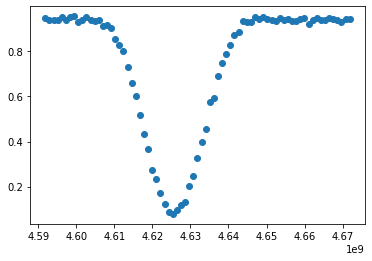

/home/whatsis/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/whatsis/.local/lib/python3.8/site-packages/qiskit/pulse/schedule.py:1534: DeprecationWarning: Legacy pulse drawer is deprecated. Specified arguments dt are deprecated. Please check the API document of new pulse drawer `qiskit.visualization.pulse_drawer_v2`.
  warnings.warn('Legacy pulse drawer is deprecated. '
[ 1.07642002e+08  4.47978365e+09 -8.20170752e+06  7.68965092e-01]
Figure(936x338.314)
Schedule((0, Play(Drag(duration=320, amp=(0.8183699822712108+0j), sigma=80, beta=-0.6793150565689698, name='drag_f7ce'), DriveChannel(0), name='drag_f7ce')), (320, Play(Waveform(array([-0.00000000e+00+0.j, -6.22619101e-03+0.j, -1.35806889e-02+0.j,
       -1.57847125e-02+0.j, -8.31358921e-03+0.j,  7.92061961e-03+0.j,
        2.57844379e-02+0.j,  3.49699095e-02+0.j,  2.761575

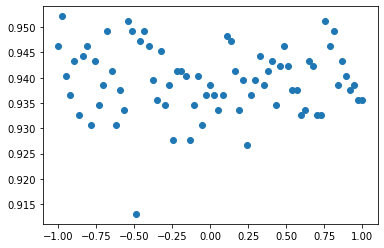

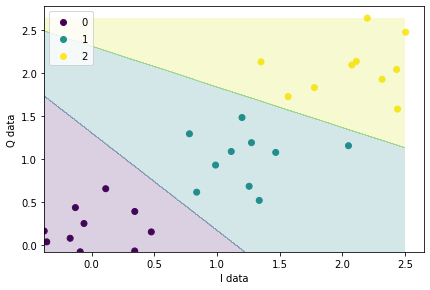

In [19]:

backend = ESPDiscriminatorBackend()
exp = ESPDiscriminatorExperiment(1)
res = exp.run(backend, shots=100, meas_level=1, meas_return="single").analysis_result(0)